# Higgs Boson Machine Learning Classification

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None #this lets pandas show all columns instead of '...'
from matplotlib import pyplot as plt

#Now import two of my functions (see their definition into the "Reference guides" folder):
from AMS_functions import NN_output_to_AMS, plot_AMS
from Plot_distributions import plot_distributions, plot_distributions_final

## Let's have a look at the dataset

In [2]:
data_full = pd.read_csv('dataset_higgs_challenge.csv')

This Set contains the following subsets, indexed by the `KaggleSet`variable:  
+  `t`: Training,
+ `b`: Public Leaderboard,
+ `v`: Privateleaderboard,
+ `u`: Unused. 

For this classification I used only yhe "t" (training data), "b" (validation data) and "v" (test data) set of variables.

In [3]:
print('Total number of events: ', len(data_full), '\n')
for KaggleSetID in ['t', 'b', 'v', 'u']:
    print('Number of events in the {} KaggleSet: {}'
          .format(KaggleSetID, len(data_full['KaggleSet'][data_full['KaggleSet']==KaggleSetID])))

Total number of events:  818238 

Number of events in the t KaggleSet: 250000
Number of events in the b KaggleSet: 100000
Number of events in the v KaggleSet: 450000
Number of events in the u KaggleSet: 18238


## Splitting of the data into training, test and validation set and feature engineering
Within the splitting of the dataset, have been applyied some operations on the engineering of the features for each subset. The problem is that the "phi" variables have a signal distribution that is very similar to the background one. So it's better to consider their linear combination (difference in this case) to make them useful in my classification.
### Replace Phi variables by their difference
+ `Delta_phi_tau_lep` = `PRI_tau_phi` - `PRI_lep_phi` (not helpful for 2 jets category)
+ `Delta_phi_met_lep` = `PRI_met_phi` - `PRI_lep_phi`
+ `Delta_phi_jet_jet` = `PRI_jet_leading_phi` - `PRI_jet_subleading_phi`
    + Drop `PRI_tau_phi`,  `PRI_lep_phi`, `PRI_met_phi`, `PRI_jet_leading_phi` and `PRI_jet_subleading_phi`

In [4]:
#Let's import my function for the splitting of the dataset into subsets (see its definition into the 
#"Reference guides" folder).
from Splitting_function import splitting

In [5]:
#Splitting of the dataset into train, test and validation set.
X = splitting (data_full, "t", "subset")
X_val = splitting (data_full, "b", "subset")
X_test = splitting (data_full, "v", "subset")

#Extracting the weights of the validation and test set:
weights_val = splitting (data_full, "b", "weights validation")
weights_test = splitting (data_full, "v", "weights test")

#Extracting the binary arrays for my networks.
y_train = splitting (data_full, "t", "binary")
y_val = splitting (data_full, "b", "binary")
y_test = splitting (data_full, "v", "binary")

#Extracting the binary arrays for my BDT.
y_train_BDT = splitting (data_full, "t", "binary BDT")
y_val_BDT = splitting (data_full, "b", "binary BDT")
y_test_BDT = splitting (data_full, "v", "binary BDT")

del(data_full)

## I) BDT Classification
I first will use a BDT model without splitting according to jet number. The class used for this is: `HistGradientBoostingClassifier` from `Sklearn`.

In [6]:
from sklearn.preprocessing import StandardScaler

#Let's first scale my data.
standard = StandardScaler()
standard.fit(X)
X_standard = standard.transform(X)
X_val_standard = standard.transform(X_val)
X_test_standard = standard.transform(X_test)


from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

Binning 0.068 GB of training data: 0.748 s
Fitting gradient boosted rounds:
[1/90] 1 tree, 50 leaves, max depth = 9, in 0.078s
[2/90] 1 tree, 50 leaves, max depth = 9, in 0.070s
[3/90] 1 tree, 50 leaves, max depth = 9, in 0.070s
[4/90] 1 tree, 50 leaves, max depth = 9, in 0.075s
[5/90] 1 tree, 50 leaves, max depth = 9, in 0.063s
[6/90] 1 tree, 50 leaves, max depth = 10, in 0.063s
[7/90] 1 tree, 50 leaves, max depth = 10, in 0.089s
[8/90] 1 tree, 50 leaves, max depth = 10, in 0.087s
[9/90] 1 tree, 50 leaves, max depth = 9, in 0.097s
[10/90] 1 tree, 50 leaves, max depth = 11, in 0.100s
[11/90] 1 tree, 50 leaves, max depth = 10, in 0.097s
[12/90] 1 tree, 50 leaves, max depth = 13, in 0.071s
[13/90] 1 tree, 50 leaves, max depth = 9, in 0.071s
[14/90] 1 tree, 50 leaves, max depth = 14, in 0.075s
[15/90] 1 tree, 50 leaves, max depth = 9, in 0.072s
[16/90] 1 tree, 50 leaves, max depth = 10, in 0.076s
[17/90] 1 tree, 50 leaves, max depth = 12, in 0.074s
[18/90] 1 tree, 50 leaves, max depth = 1

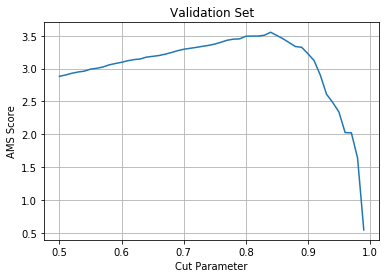

The best AMS Score is 3.578 at a Cut Parameter of 0.83


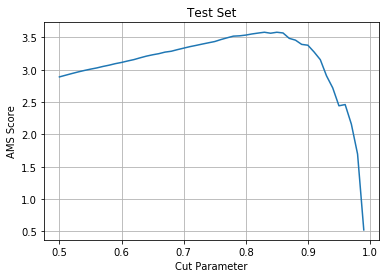

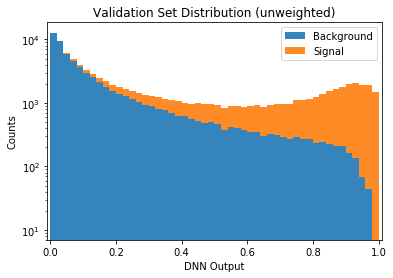

In [7]:
BDT = HistGradientBoostingClassifier(max_iter=90, verbose=1, l2_regularization=0.5, learning_rate=.1, max_leaf_nodes=50, 
                                     random_state=45, max_depth=15, max_bins=50)
BDT.fit(X_standard, y_train_BDT)

y_pred_val = BDT.predict_proba(X_val_standard)
y_pred_test = BDT.predict_proba(X_test_standard)

plot_AMS(y_pred_val, y_val, weights_val)
plt.title("Validation Set")
plt.show()
plot_AMS(y_pred_test, y_test, weights_test)
plt.title("Test Set")
plt.show()

plot_distributions(y_pred_val, y_val, 50, weighted=False, weights = None)

del X_standard, X_val_standard, X_test_standard

I will split the results just to be able to combine them with the DNN result later

In [8]:
BDT_0jets_val = y_pred_val[ X_val['PRI_jet_num']==0 ]
BDT_1jet_val = y_pred_val[ X_val['PRI_jet_num']==1 ]
BDT_2jets_val = y_pred_val[ X_val['PRI_jet_num']>=2 ]

y_pred_BDT_val = np.concatenate((BDT_0jets_val, BDT_1jet_val, BDT_2jets_val))


BDT_0jets_test = y_pred_test[ X_test['PRI_jet_num']==0 ]
BDT_1jet_test = y_pred_test[ X_test['PRI_jet_num']==1 ]
BDT_2jets_test = y_pred_test[ X_test['PRI_jet_num']>=2 ]

y_pred_BDT_test = np.concatenate((BDT_0jets_test, BDT_1jet_test, BDT_2jets_test))

## II) DNN Classification
### Build subsets according to the number of jets because of the different event topologies

Since the BDT model seems to work better without dropping the features and the DNN seems to work better after dropping, I put this here. 

Moreover, the HistBDT can handle these -999 values very well, but for the DNN it helped to set them to the mean.

Now I have to construct three subsets according to the number of jets:
+ 0 jets.
+ 1 jet.
+  \>= 2 jets.

I drop the features in which I have a value equal to -999.

In [9]:
#Now import one of my functions (see their definition into the "Reference guides" folder):
from Splitting_jets_function import splitting_jets

In [10]:
#Let's construct the data for the case with 0 jets:
X_0jets = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "subset")
X_val_0jets = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "subset_val")
X_test_0jets = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "subset_test")
y_train_0jets = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "binary_train")
y_val_0jets = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "binary_val")
y_test_0jets = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "binary_test")
weights_0jets_val = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "weights_val")
weights_0jets_test = splitting_jets(X, X_val, X_test, 0, y_train, y_val, y_test, weights_val, weights_test, "weights_test")

#Let's construct the data for the case with 1 jet:
X_1jet = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "subset")
X_val_1jet = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "subset_val")
X_test_1jet = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "subset_test")
y_train_1jet = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "binary_train")
y_val_1jet = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "binary_val")
y_test_1jet = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "binary_test")
weights_1jet_val = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "weights_val")
weights_1jet_test = splitting_jets(X, X_val, X_test, 1, y_train, y_val, y_test, weights_val, weights_test, "weights_test")

#Let's construct the data for the case with 2 jets:
X_2jets = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "subset")
X_val_2jets = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "subset_val")
X_test_2jets = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "subset_test")
y_train_2jets = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "binary_train")
y_val_2jets = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "binary_val")
y_test_2jets = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "binary_test")
weights_2jets_val = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "weights_val")
weights_2jets_test = splitting_jets(X, X_val, X_test, 2, y_train, y_val, y_test, weights_val, weights_test, "weights_test")

/home/gianluca/Splitting_jets_function.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['DER_mass_MMC'][subset['DER_mass_MMC']==-999.] = np.mean(subset['DER_mass_MMC'][subset['DER_mass_MMC']!=-999.])
/home/gianluca/Splitting_jets_function.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_val['DER_mass_MMC'][subset_val['DER_mass_MMC']==-999.] = np.mean(subset_val['DER_mass_MMC'][subset_val['DER_mass_MMC']!=-999.])
/home/gianluca/Splitting_jets_function.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

### Lets plot some of the new features
Let's verify now if my features given by the linear combination of "phi" variables are good for the classification.

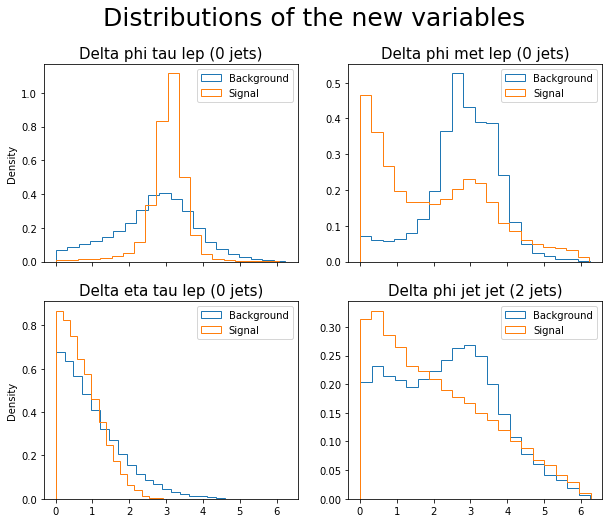

In [11]:
a1 = X_0jets['Delta_phi_tau_lep']
a2 = X_0jets['Delta_phi_met_lep']
a3 = X_0jets['Delta_eta_tau_lep']
a4 = X_2jets['Delta_phi_jet_jet']

fig, ax = plt.subplots(2,2, figsize=(10,8), sharex=True)

ax[0,0].hist(a1[y_train_0jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[0,0].hist(a1[y_train_0jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[0,0].set_title('Delta phi tau lep (0 jets)', fontsize=15)
ax[0,0].set_ylabel('Density')

ax[0,1].hist(a2[y_train_0jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[0,1].hist(a2[y_train_0jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[0,1].set_title('Delta phi met lep (0 jets)', fontsize=15)

ax[1,0].hist(a3[y_train_0jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[1,0].hist(a3[y_train_0jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[1,0].set_title('Delta eta tau lep (0 jets)', fontsize=15)
ax[1,0].set_ylabel('Density')

ax[1,1].hist(a4[y_train_2jets[:,0]==1], density=True, histtype='step', bins=20, label='Background')
ax[1,1].hist(a4[y_train_2jets[:,0]==0], density=True, histtype='step', bins=20, label='Signal')
ax[1,1].set_title('Delta phi jet jet (2 jets)', fontsize=15)

plt.suptitle('Distributions of the new variables', fontsize=25)
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()


#plt.savefig('new_variables.png', dpi=300)

del a1, a2, a3, a4

### Import some other functions
I used the library "keras" for the construction of my DNN.

In [12]:
from sklearn.preprocessing import StandardScaler #This is the best one

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l1, l2
from keras.callbacks.callbacks import EarlyStopping

#Let's import my function for the construction of my model (see its definition into the "Reference guides" folder):
from Make_model import make_model

Using TensorFlow backend.
/home/gianluca/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gianluca/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gianluca/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gianluca/.local/lib/python3.6/site-packages/tensorflo

## 2-jets Classification

I first started scaling my data.

In [13]:
standard_2jets = StandardScaler()
standard_2jets.fit(X_2jets)
X_2jets_standard = standard_2jets.transform(X_2jets)
X_val_2jets_standard = standard_2jets.transform(X_val_2jets)
X_test_2jets_standard = standard_2jets.transform(X_test_2jets)

Now let's perform a DNN

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 72543 samples, validate on 29046 samples
Epoch 1/50
72543/72543 [==============================] - 2s 32us/step - loss: 0.4796 - accuracy: 0.7921 - val_loss: 0.4006 - val_accuracy: 0.8367
Epoch 2/50
72543/72543 [==============================] - 2s 23us/step - loss: 0.4061 - accuracy: 0.8379 - val_loss: 0.3846 - val_accuracy: 0.8430
Epoch 3/50
72543/72543 [==============================] - 2s 23us/step - loss: 0.3905 - accuracy: 0.8436 - val_loss: 0.3811 - val_accuracy: 0.8432
Epoch 4/50
72543/72543 [==============================] - 2s 23us/step - loss: 0.3815 - accuracy: 0.8475 - val_loss: 0.3760 - val_accuracy: 0.8471
Epoch 5/50
72543/72543 [==============================] - 2s 23us/step - loss: 0.3750 - accuracy: 0.8488 - val_loss: 0.3706 - val_accuracy: 0.8476
Epoch 6/50
72543/72543 [==============================] - 2s 23us/step - loss: 0.3703 - accuracy: 0.8505 - val_loss: 0.3

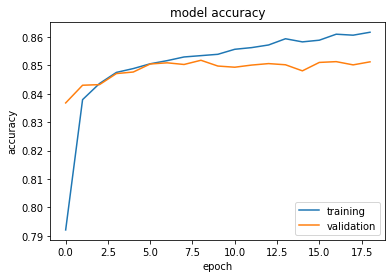

The best AMS Score is 2.807 at a Cut Parameter of 0.97


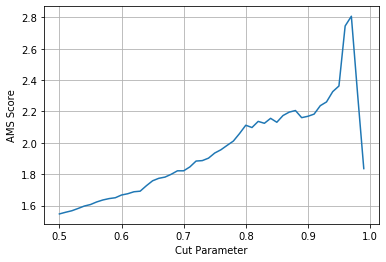

The best AMS Score is 2.359 at a Cut Parameter of 0.95


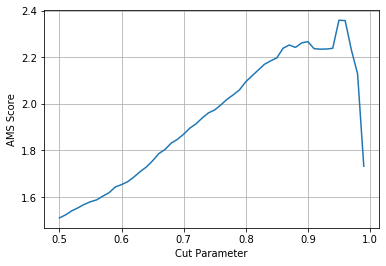

In [14]:
np.random.seed(42)
DNN_2jets = make_model([64, 128, 64, 64, 32, 8], 'relu', 0.1, 'Adam', 'L2', 0.0001, X_2jets.shape[-1])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = DNN_2jets.fit(X_2jets_standard, y_train_2jets, batch_size=256, epochs=50, verbose=1, 
                  validation_data=(X_val_2jets_standard, y_val_2jets), callbacks = [early_stopping], class_weight = None)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

y_pred_2jets_val = DNN_2jets.predict(X_val_2jets_standard)
y_pred_2jets_test = DNN_2jets.predict(X_test_2jets_standard)
plot_AMS(y_pred_2jets_val, y_val_2jets, weights_2jets_val)
plt.show()
plt.grid()
plot_AMS(y_pred_2jets_test, y_test_2jets, weights_2jets_test)
plt.grid()

In [15]:
del X_2jets_standard, X_val_2jets_standard, X_2jets, X_val_2jets, X_test_2jets_standard, X_test_2jets, 

## 1-jet Classification
Now let's do the same with the other subsets.

In [16]:
standard_1jet = StandardScaler()
standard_1jet.fit(X_1jet)
X_1jet_standard = standard_1jet.transform(X_1jet)
X_val_1jet_standard = standard_1jet.transform(X_val_1jet)
X_test_1jet_standard = standard_1jet.transform(X_test_1jet)

Train on 77544 samples, validate on 30791 samples
Epoch 1/50
77544/77544 [==============================] - 1s 19us/step - loss: 0.5736 - accuracy: 0.7878 - val_loss: 0.5176 - val_accuracy: 0.8098
Epoch 2/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.5212 - accuracy: 0.8103 - val_loss: 0.5005 - val_accuracy: 0.8144
Epoch 3/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.5075 - accuracy: 0.8129 - val_loss: 0.4915 - val_accuracy: 0.8165
Epoch 4/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.4979 - accuracy: 0.8149 - val_loss: 0.4855 - val_accuracy: 0.8158
Epoch 5/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.4915 - accuracy: 0.8164 - val_loss: 0.4804 - val_accuracy: 0.8174
Epoch 6/50
77544/77544 [==============================] - 1s 18us/step - loss: 0.4860 - accuracy: 0.8176 - val_loss: 0.4754 - val_accuracy: 0.8193
Epoch 7/50
77544/77544 [==============================] - 1s 18us/st

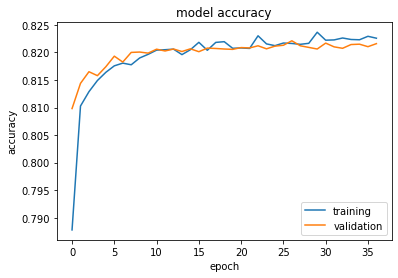

The best AMS Score is 1.642 at a Cut Parameter of 0.86


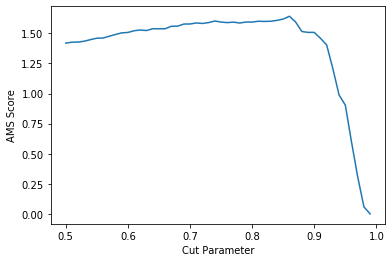

The best AMS Score is 1.659 at a Cut Parameter of 0.80


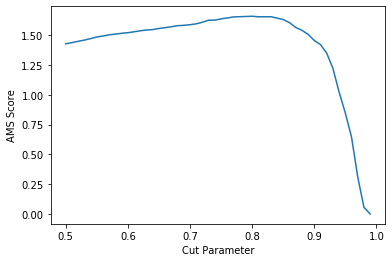

In [17]:
np.random.seed(42)
DNN_1jet = make_model([64, 64, 64, 32, 8], 'relu', 0.1, 'Adagrad', 'L1', 0.0001, X_1jet.shape[-1])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = DNN_1jet.fit(X_1jet_standard, y_train_1jet, batch_size=256, epochs=50, verbose=1, 
                  validation_data=(X_val_1jet_standard, y_val_1jet), callbacks = [early_stopping], class_weight = None)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

y_pred_1jet_val = DNN_1jet.predict(X_val_1jet_standard)
y_pred_1jet_test = DNN_1jet.predict(X_test_1jet_standard)
plot_AMS(y_pred_1jet_val, y_val_1jet, weights_1jet_val)
plt.grid()
plt.show()
plot_AMS(y_pred_1jet_test, y_test_1jet, weights_1jet_test)
plt.grid()

In [18]:
del X_1jet_standard, X_val_1jet_standard, X_1jet, X_val_1jet,  X_test_1jet_standard, X_test_1jet, 

## 0-jets Classification

In [19]:
standard_0jets = StandardScaler()
standard_0jets.fit(X_0jets)
X_0jets_standard = standard_0jets.transform(X_0jets)
X_val_0jets_standard = standard_0jets.transform(X_val_0jets)
X_test_0jets_standard = standard_0jets.transform(X_test_0jets)

Train on 99913 samples, validate on 40163 samples
Epoch 1/50
99913/99913 [==============================] - 3s 26us/step - loss: 0.5488 - accuracy: 0.8371 - val_loss: 0.5110 - val_accuracy: 0.8429
Epoch 2/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.4997 - accuracy: 0.8432 - val_loss: 0.4820 - val_accuracy: 0.8444
Epoch 3/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.4755 - accuracy: 0.8437 - val_loss: 0.4619 - val_accuracy: 0.8469
Epoch 4/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.4583 - accuracy: 0.8456 - val_loss: 0.4499 - val_accuracy: 0.8446
Epoch 5/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.4459 - accuracy: 0.8456 - val_loss: 0.4386 - val_accuracy: 0.8452
Epoch 6/50
99913/99913 [==============================] - 2s 24us/step - loss: 0.4355 - accuracy: 0.8461 - val_loss: 0.4319 - val_accuracy: 0.8441
Epoch 7/50
99913/99913 [==============================] - 2s 24us/st

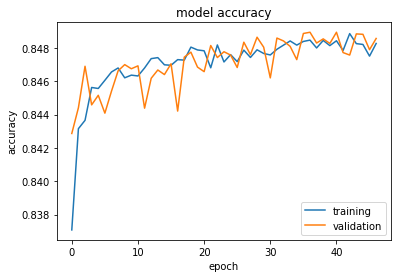

The best AMS Score is 2.448 at a Cut Parameter of 0.78


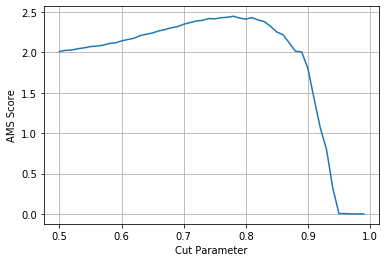

The best AMS Score is 2.433 at a Cut Parameter of 0.81


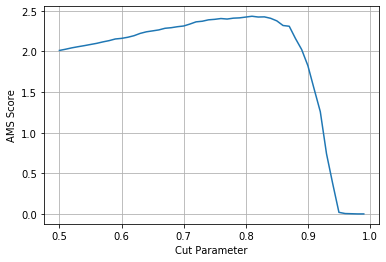

In [20]:
np.random.seed(42)
DNN_0jets = make_model([32, 64, 128, 64, 32, 8], 'elu', 0.1, 'Adagrad', 'L1', 0.0001, X_0jets.shape[-1])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = DNN_0jets.fit(X_0jets_standard, y_train_0jets, batch_size=256, epochs=50, verbose=1, 
                  validation_data=(X_val_0jets_standard, y_val_0jets), callbacks = [early_stopping], class_weight = None)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

y_pred_0jets_val = DNN_0jets.predict(X_val_0jets_standard)
y_pred_0jets_test = DNN_0jets.predict(X_test_0jets_standard)
plot_AMS(y_pred_0jets_val, y_val_0jets, weights_0jets_val)
plt.show()
plot_AMS(y_pred_0jets_test, y_test_0jets, weights_0jets_test)

In [21]:
del X_0jets_standard, X_val_0jets_standard, X_0jets, X_val_0jets, X_test_0jets_standard, X_test_0jets, 

## Total AMS Score from our DNNs
Total AMS score considering all the AMS of each subset:

In [22]:
y_pred_DNN_val = np.concatenate((y_pred_0jets_val, y_pred_1jet_val, y_pred_2jets_val))
y_val_total = np.concatenate((y_val_0jets, y_val_1jet, y_val_2jets))
weights_total_val = np.concatenate((weights_0jets_val, weights_1jet_val, weights_2jets_val))

y_pred_DNN_test = np.concatenate((y_pred_0jets_test, y_pred_1jet_test, y_pred_2jets_test))
y_test_total = np.concatenate((y_test_0jets, y_test_1jet, y_test_2jets))
weights_total_test = np.concatenate((weights_0jets_test, weights_1jet_test, weights_2jets_test))

The best AMS Score is 3.473 at a Cut Parameter of 0.81


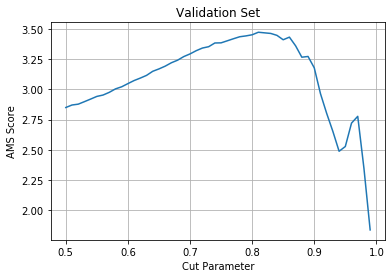

The best AMS Score is 3.532 at a Cut Parameter of 0.83


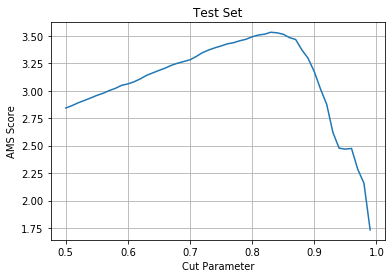

In [23]:
plot_AMS(y_pred_DNN_val, y_val_total, weights_total_val)
plt.title("Validation Set")
plt.show()
plt.title("Test Set")
plot_AMS(y_pred_DNN_test, y_test_total, weights_total_test)

## Combination of both Outputs

### The average of both gets a significantly better result!
I will now try the logistic regression for the combination of the AMS of DDN and BDT.

In [24]:
from sklearn.linear_model import LogisticRegression
dataset_blend_val = np.append(y_pred_DNN_val[:,1].reshape(-1,1), y_pred_BDT_val[:,1].reshape(-1,1), axis=1)
dataset_blend_test = np.append(y_pred_DNN_test[:,1].reshape(-1,1), y_pred_BDT_test[:,1].reshape(-1,1), axis=1)
blend = LogisticRegression(solver='lbfgs')
blend.fit(dataset_blend_val,  y_val_total[:,1])
blended_val = blend.predict_proba(dataset_blend_val)
blended_test = blend.predict_proba(dataset_blend_test)

DNN:
The best AMS Score is 3.473 at a Cut Parameter of 0.81
BDT:
The best AMS Score is 3.555 at a Cut Parameter of 0.84
Combination:
The best AMS Score is 3.600 at a Cut Parameter of 0.88


(2.8, 3.7798441766287314)

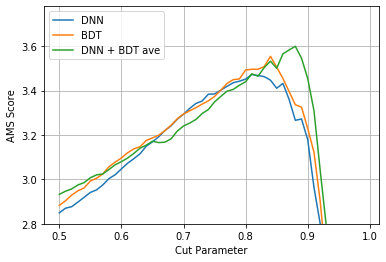

In [25]:
print('DNN:')
plot_AMS(y_pred_DNN_val, y_val_total, weights_total_val)
print('BDT:')
plot_AMS(y_pred_BDT_val, y_val_total, weights_total_val)
print('Combination:')
plot_AMS(blended_val, y_val_total, weights_total_val)
#plot_AMS(blended, y_val_total, weights_total)
plt.legend(['DNN', 'BDT', 'DNN + BDT ave'])
plt.ylim(2.8,)

## Final Result

DNN:
The best AMS Score is 3.532 at a Cut Parameter of 0.83
BDT:
The best AMS Score is 3.578 at a Cut Parameter of 0.83
Combination:
The best AMS Score is 3.653 at a Cut Parameter of 0.88


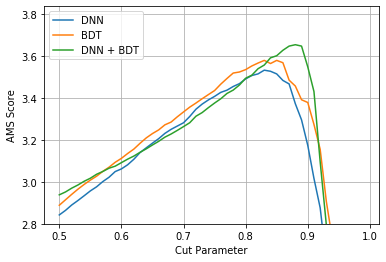

In [26]:
print('DNN:')
plot_AMS(y_pred_DNN_test, y_test_total, weights_total_test)
print('BDT:')
plot_AMS(y_pred_BDT_test, y_test_total, weights_total_test)
print('Combination:')
plot_AMS(blended_test, y_test_total, weights_total_test)
#plot_AMS(blended, y_val_total, weights_total)
plt.legend(['DNN', 'BDT', 'DNN + BDT'])
plt.ylim(2.8,)
plt.savefig('AMS_total.png', dpi=300)

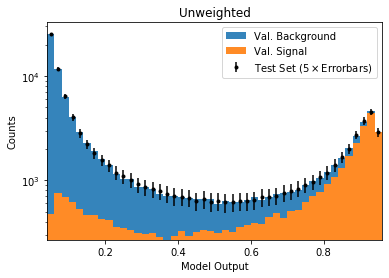

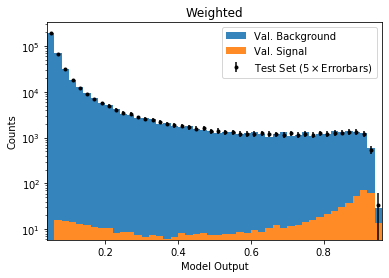

In [27]:
plot_distributions_final(blended_val, blended_test, y_val_total, 50, False, weights_total_val, 
                         weights_total_test)
plt.savefig('Final_distribution_unweighted.png', dpi=300)
plt.show()

plot_distributions_final(blended_val, blended_test, y_val_total, 50, True, weights_total_val, 
                         weights_total_test)
plt.savefig('Final_distribution_weighted.png', dpi=300)